In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf # 런타임 재시작 필요

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
import optuna

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'
SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)


In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer, mean_squared_log_error

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train.csv")

train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
accident_df = pd.read_csv(f"{DATA_PATH}countrywide_accident.csv")
DG_cctv = pd.read_csv(f"{DATA_PATH}대구 CCTV 정보.csv", encoding='cp949')
DG_parking = pd.read_csv(f"{DATA_PATH}대구 주차장 정보.csv", encoding='cp949')
DG_children_area = pd.read_csv(f"{DATA_PATH}대구 어린이 보호 구역 정보.csv", encoding='cp949')
DG_seculight = pd.read_csv(f"{DATA_PATH}대구 보안등 정보.csv", encoding='cp949')
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')
KR_seculight =pd.read_csv(f'{DATA_PATH}전국보안등정보표준데이터.csv', encoding='cp949')
KR_children_area = pd.read_csv(f'{DATA_PATH}전국어린이보호구역표준데이터.csv', encoding='cp949')
KR_parking = pd.read_csv(f'{DATA_PATH}전국주차장정보표준데이터.csv', encoding='cp949')

train_df.shape, test_df.shape

((39609, 23), (10963, 8))

- train_df, test_df

In [ ]:
train_df = pd.concat([train_df,accident_df], axis= 0).reset_index()


In [ ]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

# test 데이터 반영
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

# test 데이터 반영
test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
train_df.shape, test_df.shape

((642384, 30), (10963, 14))

- 대구의 eclo max값까지로 이상치 제거

In [ ]:
train_df[train_df['도시'] == '대구광역시']['ECLO'].max()

74

In [ ]:
mask = train_df['ECLO'] > 74
train_df = train_df[~mask]

- 총 5개 항목 도시 제거 (EDA참고)

In [ ]:
rmv_city = ['세종특별자치시', '미분류', 'nan', '', '서울특별시', '경기도']
mask = ~train_df['도시'].isin(rmv_city)
train_df = train_df[mask]

- 전국 보안등

In [ ]:
KR_seculight =pd.read_csv(f'{DATA_PATH}전국보안등정보표준데이터.csv', encoding='cp949').fillna(0)

KR_seculight = KR_seculight[KR_seculight['데이터기준일자'] <= '2021.12.31'].iloc[:,:8]

KR_seculight_df = pd.concat([KR_seculight, DG_seculight], axis=0).reset_index().drop(columns = 'index')

KR_seculight_df.shape, KR_seculight.shape, DG_seculight.shape

((86467, 8), (14554, 8), (71913, 8))

- 전국 어린이 보호구역

In [ ]:
KR_children_area = pd.read_csv(f'{DATA_PATH}전국어린이보호구역표준데이터.csv', encoding='cp949')

KR_children_area = KR_children_area.fillna(0)

KR_children_area = KR_children_area[KR_children_area['데이터기준일자'] <= '2021.12.31'].iloc[:,:12]

KR_children_area_df = pd.concat([KR_children_area,DG_children_area], axis=0).reset_index().drop(columns = 'index')

KR_children_area_df.shape, KR_children_area.shape, DG_children_area.shape

((1146, 12), (506, 12), (640, 12))

- 전국 cctv

In [ ]:
KR_cctv = pd.read_csv(f'{DATA_PATH}전국무인교통단속카메라표준데이터.csv', encoding='cp949')

KR_cctv = KR_cctv.fillna(0)
KR_cctv = KR_cctv[KR_cctv['데이터기준일자'] <= '2021.12.31']

drop_cols = ['관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드','제공기관명']
KR_cctv = KR_cctv.drop(columns = drop_cols)

KR_cctv_df = pd.concat([KR_cctv,DG_cctv], axis=0).reset_index().drop(columns = 'index')

KR_cctv_df.shape, KR_cctv.shape, DG_cctv.shape

((1409, 18), (344, 18), (1065, 18))

- 전국 주차장

In [ ]:
KR_parking = pd.read_csv(f'{DATA_PATH}전국주차장정보표준데이터.csv', encoding='cp949')

drop_cols = ['관리기관명', '전화번호','장애인전용주차구역보유여부','제공기관코드', '제공기관명']
KR_parking = KR_parking.drop(columns = drop_cols)

KR_parking = KR_parking.fillna(0)
KR_parking = KR_parking[KR_parking['데이터기준일자'] <= '2021.12.31']

KR_parking_df = pd.concat([KR_parking,DG_parking], axis=0).reset_index().drop(columns = 'index')

KR_parking_df.shape, KR_parking.shape, DG_parking.shape

((1716, 29), (845, 29), (871, 29))

# Feature 1

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
train_ft1 = pd.concat([train,accident_df], axis= 0).reset_index()

In [ ]:

# 시간
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_ft1[['연', '월', '일', '시간']] = train_ft1['사고일시'].str.extract(time_pattern)
train_ft1[['연', '월', '일', '시간']] = train_ft1[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_ft1 = train_ft1.drop(columns=['사고일시'])

# 시군구
location_pattern = r'(\S+) (\S+) (\S+)'

train_ft1[['도시', '구', '동']] = train_ft1['시군구'].str.extract(location_pattern)
train_ft1 = train_ft1.drop(columns=['시군구'])

# 도로형태

road_pattern = r'(.+) - (.+)'

train_ft1[['도로형태1', '도로형태2']] = train_ft1['도로형태'].str.extract(road_pattern)
train_ft1 = train_ft1.drop(columns=['도로형태'])

In [ ]:
df = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].std().reset_index().iloc[:,1:]

# 실험
df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['사고유형 - 세부분류','median','mean','count','sum','min','max','std']
# df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
# df_acc['max_median'] = df_acc['max'] * df_acc['median']
# df_acc['max_std'] = df_acc['max'] * df_acc['std']
# df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
# df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
# df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
# df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
# df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) * df_acc['median']
df_acc['max_std_count_log'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['std']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_std_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['사고유형 - 세부분류'].tolist()

In [ ]:
df_cols

['추돌',
 '측면충돌',
 '정면충돌',
 '기타',
 '공작물충돌',
 '전도전복 - 전복',
 '전도전복 - 전도',
 '도로외이탈 - 기타',
 '횡단중',
 '도로외이탈 - 추락',
 '길가장자리구역통행중',
 '후진중충돌',
 '차도통행중',
 '보도통행중',
 '철길건널목',
 '주/정차차량 충돌']

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['사고유형 - 세부분류_sorted'] = train_ft1['사고유형 - 세부분류'].map(label_mapping)

# for col in train_ft1[['사고유형 - 세부분류_sorted', '사고유형 - 세부분류']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
df = train_ft1.groupby(['법규위반'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['법규위반'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['법규위반'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['법규위반'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['법규위반'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['법규위반'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['법규위반'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['법규위반','median','mean','count','sum','min','max','std']
# df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
# df_acc['max_median'] = df_acc['max'] * df_acc['median']
# df_acc['max_std'] = df_acc['max'] * df_acc['std']
# df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
# df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
# df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
# df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
# df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
# df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
# df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']
df_acc['max_std_count_log'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['std']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_std_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['법규위반'].tolist()

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['법규위반_sorted'] = train_ft1['법규위반'].map(label_mapping)

# for col in train_ft1[['법규위반_sorted', '법규위반']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
df = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['가해운전자 차종','median','mean','count','sum','min','max','std']
# df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
# df_acc['max_median'] = df_acc['max'] * df_acc['median']
# df_acc['max_std'] = df_acc['max'] * df_acc['std']
# df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
# df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
# df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
# df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
# df_acc['max_count_log_mean_log'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
# df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
# df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']
# df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['mean']
df_acc['max_std_count_log'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['std']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_std_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['가해운전자 차종'].tolist()

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['가해운전자 차종_sorted'] = train_ft1['가해운전자 차종'].map(label_mapping)

# for col in train_ft1[['가해운전자 차종_sorted', '가해운전자 차종']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
df = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['피해운전자 차종','median','mean','count','sum','min','max','std']
# df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
# df_acc['max_median'] = df_acc['max'] * df_acc['median']
# df_acc['max_std'] = df_acc['max'] * df_acc['std']
# df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
# df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
# df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
# df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
# df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
# df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
# df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']
df_acc['max_std_count_log'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['std']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_std_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['피해운전자 차종'].tolist()

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['피해운전자 차종_sorted'] = train_ft1['피해운전자 차종'].map(label_mapping)

# for col in train_ft1[['피해운전자 차종_sorted', '피해운전자 차종']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
df = train_ft1.groupby(['피해운전자 상해정도'])[['ECLO']].mean().reset_index()
df1 = train_ft1.groupby(['피해운전자 상해정도'])[['ECLO']].min().reset_index().iloc[:,1:]

df_acc = pd.concat([df,df1], axis=1)
df_acc.columns = ['피해운전자 상해정도','mean','min']
df_acc = df_acc.sort_values(by='min', ascending=False)

df_cols = df_acc['피해운전자 상해정도'].tolist()

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['피해운전자 상해정도_sorted'] = train_ft1['피해운전자 상해정도'].map(label_mapping)

# for col in train_ft1[['피해운전자 상해정도_sorted', '피해운전자 상해정도']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
df = train_ft1.groupby(['가해운전자 상해정도'])[['ECLO']].mean().reset_index()
df1 = train_ft1.groupby(['가해운전자 상해정도'])[['ECLO']].min().reset_index().iloc[:,1:]

df_acc = pd.concat([df,df1], axis=1)
df_acc.columns = ['가해운전자 상해정도','mean','min']
df_acc = df_acc.sort_values(by='min', ascending=False)

df_cols = df_acc['가해운전자 상해정도'].tolist()

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['가해운전자 상해정도_sorted'] = train_ft1['가해운전자 상해정도'].map(label_mapping)

# for col in train_ft1[['가해운전자 상해정도_sorted', '가해운전자 상해정도']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['가해운전자 상해정도_sorted'] = train_ft1['가해운전자 상해정도'].map(label_mapping)

In [ ]:
# for col in train_ft1[['가해운전자 상해정도_sorted', '가해운전자 상해정도']]:
#     sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
#     break

In [ ]:
import re

train_ft1['가해운전자 연령'] = train_ft1['가해운전자 연령'].apply(lambda x: re.sub(r'\D', '', str(x)))
train_ft1['가해운전자 연령_sorted'] = pd.to_numeric(train_ft1['가해운전자 연령'], errors='coerce')

train_ft1['피해운전자 연령'] = train_ft1['피해운전자 연령'].apply(lambda x: re.sub(r'\D', '', str(x)))
train_ft1['피해운전자 연령_sorted'] = pd.to_numeric(train_ft1['피해운전자 연령'], errors='coerce')


In [ ]:
gender_mapping = {'남': 0, '기타불명': 1, '여': 2}

train_ft1['가해운전자 성별_sorted'] = train_ft1['가해운전자 성별'].map(gender_mapping)
train_ft1['피해운전자 성별_sorted'] = train_ft1['피해운전자 성별'].map(gender_mapping)

train_ft1['가해운전자 성별_sorted'] = pd.to_numeric(train_ft1['가해운전자 성별_sorted'], errors='coerce')
train_ft1['피해운전자 성별_sorted'] = pd.to_numeric(train_ft1['피해운전자 성별_sorted'], errors='coerce')

In [ ]:
feature_1 = ['사고유형 - 세부분류_sorted', '법규위반_sorted',
             '가해운전자 차종_sorted', '피해운전자 차종_sorted',
             '가해운전자 연령_sorted', '피해운전자 연령_sorted',
             '가해운전자 성별_sorted', '피해운전자 성별_sorted',
             '가해운전자 상해정도_sorted', '피해운전자 상해정도_sorted']

- merge

In [ ]:
def categorize_time_period(hour):
    if 6 <= hour < 9:  # 아침 출퇴근 시간
        return 0
    elif 9 <= hour < 12:  # 아침
        return 1
    elif 12 <= hour < 14:  # 점심
        return 2
    elif 14 <= hour < 18:  # 오후
        return 3
    elif 18 <= hour < 21:  # 저녁
        return 4
    elif 21 <= hour < 24:  # 밤
        return 5
    else:  # 새벽
        return 6

train_ft1['시간대'] = train_ft1['시간'].apply(categorize_time_period)

train_df['시간대'] = train_df['시간'].apply(categorize_time_period)
test_df['시간대'] = test_df['시간'].apply(categorize_time_period)

In [ ]:
abs(train_ft1.corr()['ECLO']).sort_values(ascending=False)

ECLO                  1.000000
경상자수                  0.608219
중상자수                  0.498507
사망자수                  0.265288
가해운전자 상해정도_sorted     0.214928
피해운전자 상해정도_sorted     0.211004
피해운전자 차종_sorted       0.186709
사고유형 - 세부분류_sorted    0.114131
가해운전자 차종_sorted       0.106702
피해운전자 연령_sorted       0.055108
피해운전자 성별_sorted       0.026261
부상자수                  0.024367
연                     0.022153
시간                    0.017772
index                 0.016435
시간대                   0.013762
가해운전자 성별_sorted       0.011035
월                     0.009884
법규위반_sorted           0.005690
일                     0.005428
가해운전자 연령_sorted       0.001990
Name: ECLO, dtype: float64

In [ ]:
feature1_merge_df = train_ft1.groupby(['구','요일','시간대','사고유형','기상상태','도로형태2'])[feature_1].mean().reset_index()

In [ ]:
feature1_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118125 entries, 0 to 118124
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   구                   118125 non-null  object 
 1   요일                  118125 non-null  object 
 2   시간대                 118125 non-null  int64  
 3   사고유형                118125 non-null  object 
 4   기상상태                118125 non-null  object 
 5   도로형태2               118125 non-null  object 
 6   사고유형 - 세부분류_sorted  118125 non-null  float64
 7   법규위반_sorted         118125 non-null  float64
 8   가해운전자 차종_sorted     118125 non-null  float64
 9   피해운전자 차종_sorted     102805 non-null  float64
 10  가해운전자 연령_sorted     117136 non-null  float64
 11  피해운전자 연령_sorted     102738 non-null  float64
 12  가해운전자 성별_sorted     118125 non-null  float64
 13  피해운전자 성별_sorted     102803 non-null  float64
 14  가해운전자 상해정도_sorted   118125 non-null  float64
 15  피해운전자 상해정도_sorted   102803 non-nul

In [ ]:
train_df = pd.merge(train_df,feature1_merge_df, on = ['구','요일','시간대','사고유형','기상상태','도로형태2'], how='left' )
test_df = pd.merge(test_df,feature1_merge_df, on = ['구','요일','시간대','사고유형','기상상태','도로형태2'], how='left' )

# Feature 2

- 기본 feature

In [ ]:
df = train_df[['도시','구','동']]

df1 = pd.get_dummies(train_df['기상상태'], prefix = '기상상태')
df2 = pd.get_dummies(train_df['노면상태'], prefix = '노면상태')
df3 = pd.get_dummies(train_df['도로형태1'], prefix = '도로형태1')
df4 = pd.get_dummies(train_df['도로형태2'], prefix = '도로형태2')
df5 = pd.get_dummies(train_df['사고유형'], prefix = '사고유형')

train_time_merge= pd.concat([df, df1, df2, df3, df4, df5], axis=1) #23개 열

In [ ]:
train_time_merge_df = train_time_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(train_time_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(train_time_merge_df, on = ['도시','구','동'], how='left')

In [ ]:
train_df.columns.tolist()

['index',
 'ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '사망자수',
 '중상자수',
 '경상자수',
 '부상자수',
 'ECLO',
 '연',
 '월',
 '일',
 '시간',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2',
 '시간대',
 '사고유형 - 세부분류_sorted',
 '법규위반_sorted',
 '가해운전자 차종_sorted',
 '피해운전자 차종_sorted',
 '가해운전자 연령_sorted',
 '피해운전자 연령_sorted',
 '가해운전자 성별_sorted',
 '피해운전자 성별_sorted',
 '가해운전자 상해정도_sorted',
 '피해운전자 상해정도_sorted',
 '기상상태_기타',
 '기상상태_눈',
 '기상상태_맑음',
 '기상상태_비',
 '기상상태_안개',
 '기상상태_흐림',
 '노면상태_건조',
 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_젖음/습기',
 '노면상태_침수',
 '노면상태_해빙',
 '도로형태1_교차로',
 '도로형태1_기타',
 '도로형태1_단일로',
 '도로형태1_미분류',
 '도로형태1_주차장',
 '도로형태2_고가도로위',
 '도로형태2_교량',
 '도로형태2_교차로부근',
 '도로형태2_교차로안',
 '도로형태2_교차로횡단보도내',
 '도로형태2_기타',
 '도로형태2_미분류',
 '도로형태2_주차장',
 '도로형태2_지하차도(도로)내',
 '도로형태2_철길건널목',
 '도로형태2_터널',
 '사고유형_차대사람',
 '사고유형_차대차',
 '사고유형_차량단독',
 '사고유형_철길건널목']

- 보안등

In [ ]:
DG_seculight = KR_seculight_df.copy()

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_seculight[['도시', '구', '동','번지']] = DG_seculight['소재지지번주소'].str.extract(location_pattern)
DG_seculight = DG_seculight.drop(columns=['소재지지번주소'])

In [ ]:
df1 = DG_seculight.groupby(['도시','구','동'])[['설치개수']].sum().reset_index()
df1.columns = ['도시','구','동','보안등_설치개수']

df2 = pd.get_dummies(DG_seculight['설치형태'], prefix='보안등')
df2 = pd.concat([DG_seculight[['도시','구','동']], df2], axis=1)
df2 = df2.groupby(['도시','구','동']).sum().reset_index().drop(columns =['도시','구','동'])

seculight_merge = pd.concat([df1, df2], axis=1)

train_df = pd.merge(train_df,seculight_merge, on = ['도시','구','동'], how='left')
test_df = pd.merge(test_df,seculight_merge, on = ['도시','구','동'], how='left')

In [ ]:
train_df.columns.tolist()

['index',
 'ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '사망자수',
 '중상자수',
 '경상자수',
 '부상자수',
 'ECLO',
 '연',
 '월',
 '일',
 '시간',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2',
 '시간대',
 '사고유형 - 세부분류_sorted',
 '법규위반_sorted',
 '가해운전자 차종_sorted',
 '피해운전자 차종_sorted',
 '가해운전자 연령_sorted',
 '피해운전자 연령_sorted',
 '가해운전자 성별_sorted',
 '피해운전자 성별_sorted',
 '가해운전자 상해정도_sorted',
 '피해운전자 상해정도_sorted',
 '기상상태_기타',
 '기상상태_눈',
 '기상상태_맑음',
 '기상상태_비',
 '기상상태_안개',
 '기상상태_흐림',
 '노면상태_건조',
 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_젖음/습기',
 '노면상태_침수',
 '노면상태_해빙',
 '도로형태1_교차로',
 '도로형태1_기타',
 '도로형태1_단일로',
 '도로형태1_미분류',
 '도로형태1_주차장',
 '도로형태2_고가도로위',
 '도로형태2_교량',
 '도로형태2_교차로부근',
 '도로형태2_교차로안',
 '도로형태2_교차로횡단보도내',
 '도로형태2_기타',
 '도로형태2_미분류',
 '도로형태2_주차장',
 '도로형태2_지하차도(도로)내',
 '도로형태2_철길건널목',
 '도로형태2_터널',
 '사고유형_차대사람',
 '사고유형_차대차',
 '사고유형_차량단독',
 '사고유형_철길건널목',
 '보안등_설치개수',
 '보안등_0',
 '보안등_건축물',
 '보안등_전

- cctv

In [ ]:
DG_cctv = KR_cctv_df.copy()

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_cctv[['도시', '구', '동','번지']] = DG_cctv['소재지지번주소'].str.extract(location_pattern)
DG_cctv = DG_cctv.drop(columns=['소재지지번주소'])

In [ ]:
DG_cctv.columns.tolist()

['무인교통단속카메라관리번호',
 '시도명',
 '시군구명',
 '도로종류',
 '도로노선번호',
 '도로노선명',
 '도로노선방향',
 '소재지도로명주소',
 '위도',
 '경도',
 '설치장소',
 '단속구분',
 '제한속도',
 '단속구간위치구분',
 '과속단속구간길이',
 '보호구역구분',
 '설치연도',
 '도시',
 '구',
 '동',
 '번지']

In [ ]:
DG_cctv['보호구역구분'] = DG_cctv['보호구역구분'].astype(float)
DG_cctv['단속구분'] = DG_cctv['단속구분'].astype(int)
DG_cctv['제한속도'] = DG_cctv['제한속도'].astype(int)

In [ ]:
df = DG_cctv[['도시','구','동']]
df['cctv_설치개수'] = 1

df1 = pd.get_dummies(DG_cctv['보호구역구분'], prefix = '보호구역구분')
df2 = pd.get_dummies(DG_cctv['단속구분'], prefix = '단속구분')
df3 = pd.get_dummies(DG_cctv['도로종류'], prefix = '도로종류')
df4 = pd.get_dummies(DG_cctv['제한속도'], prefix = '제한속도')

cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1)

cctv_merge_df = cctv_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')

In [ ]:
train_df.columns.tolist()

['index',
 'ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '사망자수',
 '중상자수',
 '경상자수',
 '부상자수',
 'ECLO',
 '연',
 '월',
 '일',
 '시간',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2',
 '시간대',
 '사고유형 - 세부분류_sorted',
 '법규위반_sorted',
 '가해운전자 차종_sorted',
 '피해운전자 차종_sorted',
 '가해운전자 연령_sorted',
 '피해운전자 연령_sorted',
 '가해운전자 성별_sorted',
 '피해운전자 성별_sorted',
 '가해운전자 상해정도_sorted',
 '피해운전자 상해정도_sorted',
 '기상상태_기타',
 '기상상태_눈',
 '기상상태_맑음',
 '기상상태_비',
 '기상상태_안개',
 '기상상태_흐림',
 '노면상태_건조',
 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_젖음/습기',
 '노면상태_침수',
 '노면상태_해빙',
 '도로형태1_교차로',
 '도로형태1_기타',
 '도로형태1_단일로',
 '도로형태1_미분류',
 '도로형태1_주차장',
 '도로형태2_고가도로위',
 '도로형태2_교량',
 '도로형태2_교차로부근',
 '도로형태2_교차로안',
 '도로형태2_교차로횡단보도내',
 '도로형태2_기타',
 '도로형태2_미분류',
 '도로형태2_주차장',
 '도로형태2_지하차도(도로)내',
 '도로형태2_철길건널목',
 '도로형태2_터널',
 '사고유형_차대사람',
 '사고유형_차대차',
 '사고유형_차량단독',
 '사고유형_철길건널목',
 '보안등_설치개수',
 '보안등_0',
 '보안등_건축물',
 '보안등_전

- 어린이 보호구역

In [ ]:
DG_children_area = KR_children_area_df.copy()

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_children_area[['도시', '구', '동','번지']] = DG_children_area['소재지지번주소'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['소재지지번주소'])

location_pattern = r'(\S+)~(\S+)'

DG_children_area[['보호구역도로폭_min', '보호구역도로폭_max']] = DG_children_area['보호구역도로폭'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['보호구역도로폭'])

In [ ]:
DG_children_area['보호구역도로폭_min'] = DG_children_area['보호구역도로폭_min'].astype(float)
DG_children_area['보호구역도로폭_max'] = DG_children_area['보호구역도로폭_max'].astype(float)

In [ ]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_children_area[['도시','구','동']]

df1 = pd.get_dummies(DG_children_area['시설종류'], prefix = '시설종류')

children_area_merge= pd.concat([df, df1], axis=1)
children_area_merge #23개 열

children_area_merge_df = children_area_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')

In [ ]:
df2 = DG_children_area.groupby(['도시','구','동'])[['CCTV설치대수']].mean().reset_index()
df3 = DG_children_area.groupby(['도시','구','동'])[['보호구역도로폭_min']].max().reset_index().iloc[:,3:]
df4 = DG_children_area.groupby(['도시','구','동'])[['보호구역도로폭_max']].max().reset_index().iloc[:,3:]

children_area_num_merge_df = pd.concat([df2, df3, df4], axis=1)


In [ ]:
train_df = train_df.merge(children_area_num_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(children_area_num_merge_df, on = ['도시','구','동'], how='left')

- 주차장

In [ ]:
DG_parking = KR_parking_df.copy()

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_parking[['도시', '구', '동','번지']] = DG_parking['소재지지번주소'].str.extract(location_pattern)
DG_parking = DG_parking.drop(columns=['소재지지번주소'])

In [ ]:
DG_parking['급지구분'].value_counts()
DG_parking['급지구분'] = DG_parking['급지구분'].replace('기타',0)
DG_parking['급지구분'] = DG_parking['급지구분'].astype(int)

In [ ]:
df = DG_parking[['도시','구','동']]

df1 = pd.get_dummies(DG_parking['주차장구분'], prefix = '주차장구분')
df2 = pd.get_dummies(DG_parking['주차장유형'], prefix = '주차장유형')
df3 = pd.get_dummies(DG_parking['급지구분'], prefix = '급지구분')
df4 = pd.get_dummies(DG_parking['부제시행구분'], prefix = '부제시행구분')
df5 = pd.get_dummies(DG_parking['운영요일'], prefix = '운영요일')
df6 = pd.get_dummies(DG_parking['요금정보'], prefix = '요금정보')
df7 = pd.get_dummies(DG_parking['결제방법'], prefix = '결제방법')


parking_merge= pd.concat([df, df1, df2, df3, df4, df5, df6, df7], axis=1)

parking_merge_df = parking_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')


In [ ]:
parking_num_cols = ['도시','구','동','주차구획수', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각','주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금' ]

df = DG_parking[parking_num_cols]

from datetime import datetime

def time_to_int(time_str):
#     time_str = time
    time_obj = datetime.strptime(time_str, "%H:%M")
    # 시간을 분 단위로 변환하고 24로 나누어 표현
    hours_decimal = (time_obj.hour * 60 + time_obj.minute) / 60.0
    return hours_decimal

df['평일운영시작시각'] = df['평일운영시작시각'].apply(time_to_int)
df['평일운영종료시각'] = df['평일운영종료시각'].apply(time_to_int)
df['토요일운영시작시각'] = df['토요일운영시작시각'].apply(time_to_int)
df['토요일운영종료시각'] = df['토요일운영종료시각'].apply(time_to_int)
df['공휴일운영시작시각'] = df['공휴일운영시작시각'].apply(time_to_int)
df['공휴일운영종료시각'] = df['공휴일운영종료시각'].apply(time_to_int)

parking_num_merge_df = df.groupby(['도시','구','동']).mean().reset_index()

train_df = train_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')


# Feature 선택, 인코딩, 변환

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
train_x = train_df.copy()
test_x = test_df.copy()

train_y = train_df['ECLO']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_df.dtypes[train_df.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

['ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 연령',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 연령',
 '피해운전자 상해정도',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

In [ ]:
basic_cols = ['ID',
 '요일',
 '기상상태',
 '노면상태',
 '사고유형',
#  '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

In [ ]:
train_df['사고유형 - 세부분류'].unique()

array(['길가장자리구역통행중', '보도통행중', '차도통행중', '추돌', '측면충돌', '기타', '공작물충돌', '횡단중',
       '정면충돌', '후진중충돌', '전도전복 - 전도', '도로외이탈 - 추락', '도로외이탈 - 기타',
       '전도전복 - 전복', '주/정차차량 충돌', '철길건널목'], dtype=object)

In [ ]:
for col in basic_cols:
    enc = TargetEncoder()
    train_df[col]=enc.fit_transform(train_df[col], y=train_df['ECLO'])
    test_df[col]=enc.transform(test_df[col])

train_df.head()

,index,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,공휴일운영시작시각,공휴일운영종료시각,주차기본시간,주차기본요금,추가단위시간,1일주차권요금적용시간,1일주차권요금
0,0,5.089753,4.963572,5.082396,5.086561,4.154970,길가장자리구역통행중,안전운전불이행,승용,여,...,20.089394,7.363636,20.089394,0.000000,2.180303,32.727273,1136.363636,30.0,NaN,NaN
1,1,4.829536,4.963572,5.311562,5.086561,4.154970,보도통행중,기타,승용,남,...,11.000000,4.500000,11.000000,4.500000,11.000000,735.000000,150.000000,10.0,NaN,NaN
2,2,4.829536,4.963572,5.082396,5.086561,4.154970,차도통행중,안전운전불이행,승용,남,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5.089753,4.963572,5.082396,5.086561,5.330686,추돌,안전운전불이행,승용,남,...,1.428571,0.571429,1.428571,0.571429,1.428571,2.142857,71.428571,60.0,NaN,10000.0
4,4,4.829536,4.963572,5.082396,5.086561,5.330686,추돌,안전운전불이행,승용,남,...,19.500000,9.000000,19.500000,9.000000,19.500000,30.000000,600.000000,10.0,3.5,6000.0


# ECLO EDA
- 도시별 ECLO분포 등 확인

In [ ]:
train_df['도시'].unique().tolist()

['대구광역시',
 '인천광역시',
 '전라남도',
 '충청남도',
 '광주광역시',
 '부산광역시',
 '강원도',
 '울산광역시',
 '전라북도',
 '경상남도',
 '경상북도',
 '충청북도',
 '대전광역시',
 '제주특별자치도',
 nan]

In [ ]:
display(parking_merge_df['도시'].unique())
display(children_area_merge_df['도시'].unique())
display(seculight_merge['도시'].unique())
display(cctv_merge_df['도시'].unique())

# 강원도, 경상북도, 대구, 부산, 서울, 충북, 충남, 전남,

array(['강원도', '경기도', '경상북도', '광주광역시', '대구광역시', '부산광역시', '서울특별시', '울산광역시',
       '인천광역시', '충청북도'], dtype=object)

array(['강원도', '경상북도', '대구광역시', '서울특별시', '전라남도', '충청북도'], dtype=object)

array(['강원도', '경상남도', '대구광역시', '부산광역시', '제주특별자치도', '충청남도'], dtype=object)

array(['경상남도', '대구', '대구광역시', '서울특별시', '전라남도', '충청남도'], dtype=object)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371014 entries, 0 to 371013
Columns: 163 entries, index to 1일주차권요금
dtypes: float64(141), int64(11), object(11)
memory usage: 464.2+ MB


In [ ]:
# # for city in train_df['도시'].unique():
# #     city_df = train_df[train_df['도시'] == city]
# #     plt.figure(figsize=(20,3))
# #     # plt.plot(city_df.index, city_df['ECLO'])
# #     plt.title(f'{city} ECLO distributions')
# #     sns.scatterplot(x=city_df.index, y = city_df['ECLO'])
# #     plt.show()

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create subplots with shared y-axis
# fig, axes = plt.subplots(nrows=len(train_df['도시'].unique()), figsize=(20, 3 * len(train_df['도시'].unique())), sharey=True)

# # Loop through each city and plot the ECLO distribution
# for i, city in enumerate(train_df['도시'].unique()):
#     city_df = train_df[train_df['도시'] == city]
#     sns.scatterplot(ax=axes[i], x=city_df.index, y=city_df['ECLO'])
#     axes[i].set_title(f'{city} ECLO distribution')

# # Add a common x-axis label
# fig.text(0.5, 0.04, 'Index', ha='center', va='center')
# # Add a common y-axis label
# fig.text(0.06, 0.5, 'ECLO', ha='center', va='center', rotation='vertical')

# plt.show()

# # 대구, 인천, 충남, 광주, 부산, 강원, 울산, 전북, 경남, 경북, 충북, 대전,제주

# #제외 : 세종, 서울, 경기도, 미분류, nan 제외


In [ ]:
train_df['도시'].unique()

array(['대구광역시', '인천광역시', '전라남도', '충청남도', '광주광역시', '부산광역시', '강원도', '울산광역시',
       '전라북도', '경상남도', '경상북도', '충청북도', '대전광역시', '제주특별자치도', nan],
      dtype=object)

- eclo평균 등등

In [ ]:
train_df.groupby(['도시'])[['피해운전자 연령_sorted']].mean()

,피해운전자 연령_sorted
도시,
강원도,47.414168
경상남도,47.640201
경상북도,48.366600
광주광역시,44.013454
대구광역시,44.506258
대전광역시,44.900049
부산광역시,45.977685
울산광역시,45.491437
인천광역시,44.460840


In [ ]:
df = train_df.groupby(['도시'])[['ECLO']].mean()
df['median'] = train_df.groupby(['도시'])[['ECLO']].median()
df['min'] = train_df.groupby(['도시'])[['ECLO']].min()
df['max'] = train_df.groupby(['도시'])[['ECLO']].max()
df['std'] = train_df.groupby(['도시'])[['ECLO']].std()
df['skew'] = train_df.groupby(['도시'])[['ECLO']].skew()
df['세부분류'] = train_df.groupby(['도시'])[['사고유형']].mean()
df

,ECLO,median,min,max,std,skew,세부분류
도시,,,,,,,
강원도,5.343464,5.0,1,58,3.719559,3.023758,5.118484
경상남도,5.218988,5.0,1,56,3.490857,3.186727,5.075284
경상북도,5.280437,5.0,1,71,3.606058,3.229793,5.123647
광주광역시,4.986342,3.0,1,56,3.346760,2.849512,5.129488
대구광역시,4.726704,3.0,1,74,3.207206,3.352093,5.118570
대전광역시,4.895079,3.0,1,64,3.235346,3.335290,5.114179
부산광역시,4.624900,3.0,1,71,3.092222,3.737526,5.031567
울산광역시,4.838397,3.0,1,56,3.199611,3.213213,5.072514
인천광역시,4.695469,3.0,1,45,3.036767,3.059008,5.092295


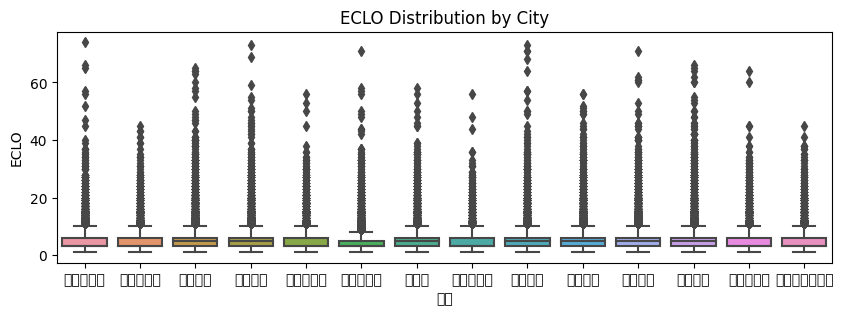

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for the 'ECLO' variable grouped by '도시'
plt.figure(figsize=(10, 3))
sns.boxplot(x='도시', y='ECLO', data=train_df)
plt.title('ECLO Distribution by City')
plt.show()

# 서울, 경기, 전남, 충북, 대전, 제주, 세종, 미분류 제외할 것!

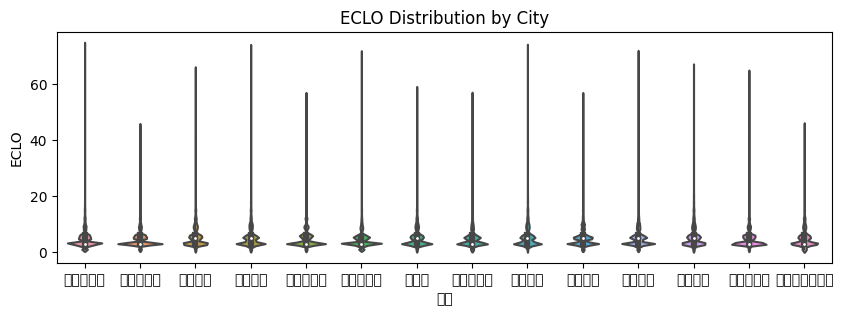

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a violin plot for the 'ECLO' variable grouped by '도시'
plt.figure(figsize=(10, 3))
sns.violinplot(x='도시', y='ECLO', data=train_df)
plt.title('ECLO Distribution by City')
plt.show()

- 각 도시별 ECLO의 커널밀도 추정

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create subplots with shared y-axis
# fig, axes = plt.subplots(nrows=len(train_df['도시'].unique()), figsize=(10, 3 * len(train_df['도시'].unique())), sharey=True)

# # Loop through each city and plot the ECLO distribution
# for i, city in enumerate(train_df['도시'].unique()):
#     city_df = train_df[train_df['도시'] == city]
#     sns.kdeplot(ax=axes[i], x=city_df['ECLO'], fill=True, common_norm=False)
#     axes[i].set_title(f'{city} ECLO distribution')

# # Add a common x-axis label
# fig.text(0.5, 0.04, 'ECLO', ha='center', va='center')
# # Add a common y-axis label
# fig.text(0.06, 0.5, 'Density', ha='center', va='center', rotation='vertical')

# plt.show()


# # 부산, 울산, 제주 대구와 비슷

In [ ]:
# city_df = train_df[train_df['도시'] == city]
# city_df = city_df.groupby(['도시','구','동'])[['ECLO']].mean().reset_index()
# city_df

In [ ]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns

# for city in tqdm(train_df['도시'].unique()):
#     plt.figure(figsize=(4,2))  # Corrected figsize argument
#     city_df = train_df[train_df['도시'] == city]
#     city_df = city_df.groupby(['도시','구','동'])[['ECLO']].mean().reset_index()
#     sns.scatterplot(x=city_df.index, y=city_df['ECLO'])  # Adjust bins as needed
#     plt.title(f'{city} ECLO Distribution')
#     plt.xlabel('ECLO')
#     plt.ylabel('Frequency')
#     plt.show()


# Feature select

In [ ]:
feature_1

['사고유형 - 세부분류_sorted',
 '법규위반_sorted',
 '가해운전자 차종_sorted',
 '피해운전자 차종_sorted',
 '가해운전자 연령_sorted',
 '피해운전자 연령_sorted',
 '가해운전자 성별_sorted',
 '피해운전자 성별_sorted',
 '가해운전자 상해정도_sorted',
 '피해운전자 상해정도_sorted']

In [ ]:
feature_2 = [
 'ID',
 '요일',

 '기상상태',
 '노면상태',
 '사고유형',

 '연',
 '월',
 '시간',

 '구',
 '동',
 '도로형태1',
 '도로형태2',

 '기상상태_기타',
 '기상상태_눈',
 '기상상태_안개',
 '기상상태_흐림',

 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_침수',

 '도로형태1_기타',
 '도로형태1_미분류',
 '도로형태1_주차장',

 '도로형태2_고가도로위',
 '도로형태2_교량',
 '도로형태2_미분류',
 '도로형태2_주차장',
 '도로형태2_지하차도(도로)내',
 '도로형태2_터널',

 '보안등_건축물',
 '보안등_전용주',
 '보안등_한전주',
 'cctv_설치개수',

 '보호구역구분_1.0',
 '보호구역구분_2.0',

 '단속구분_1',
 '단속구분_4',
 '단속구분_99',

 '도로종류_고속국도',
 '도로종류_구도',
 '도로종류_시도',
 '도로종류_일반국도',
 '도로종류_지방도',

 '제한속도_0',
 '제한속도_30',
 '제한속도_40',
 '제한속도_60',
 '제한속도_70',
 '제한속도_80',
 '제한속도_100',

 '시설종류_어린이집',
 '시설종류_초등학교',
 '시설종류_특수학교',
 '시설종류_학원',

 'CCTV설치대수',
 '보호구역도로폭_min',
 '보호구역도로폭_max',

 '주차장구분_민영',
 '주차장유형_노외',

 '급지구분_1',
 '급지구분_3',

 '운영요일_평일',
 '운영요일_평일+토요일',

 '요금정보_무료',
 '요금정보_유료',
 '요금정보_혼합',

 '결제방법_무료',
 '결제방법_신용카드',
 '결제방법_카드',
 '결제방법_현금',
 '결제방법_현금,카드',

 '주차구획수',
 '공휴일운영시작시각',
 '주차기본시간',
 '주차기본요금',

]


In [ ]:
test_x = test_df[feature_1 + feature_2].drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()

train_y = train_df['ECLO'].copy()

test_x.shape, train_x.shape, train_y.shape

((10963, 84), (371014, 84), (371014,))

In [ ]:
feature_original = ['기상상태', '노면상태', '기상상태_눈', '도로형태2_미분류', '도로형태1_미분류', '연', '구', '동', '월', '요일',
                    '도로형태2', '시간', '가해운전자 연령_sorted', '사고유형', '피해운전자 연령_sorted',
                    '피해운전자 상해정도_sorted','가해운전자 상해정도_sorted']

feature_log = ['보안등_전용주', '주차구획수', '도로형태2_터널', '보안등_한전주', '도로형태2_지하차도(도로)내', '운영요일_평일', '도로종류_일반국도',
            '요금정보_혼합', '단속구분_4', '제한속도_0', '급지구분_3', '제한속도_30', '요금정보_무료', '주차장유형_노외', '사고유형 - 세부분류_sorted',
               '도로종류_구도', '시설종류_초등학교', 'cctv_설치개수', '도로형태2_고가도로위', '요금정보_유료', '노면상태_기타',
               '결제방법_현금', '도로형태2_교량', '제한속도_60', '시설종류_어린이집', '주차기본시간', '노면상태_서리/결빙', '제한속도_40',
               '단속구분_1', '보호구역구분_2.0', '도로형태2_주차장', '도로형태1_주차장']

feature_sqrt = ['운영요일_평일+토요일', '가해운전자 차종_sorted', '급지구분_1', '공휴일운영시작시각', 'CCTV설치대수', '기상상태_기타',
                '주차기본요금', '법규위반_sorted', '피해운전자 성별_sorted', '가해운전자 성별_sorted', '도로형태1_기타',
                '피해운전자 차종_sorted', '기상상태_흐림', '도로형태1']

In [ ]:
train_x = train_x.astype(float)
test_x = test_x.astype(float)

In [ ]:
log_cols = []
for col in feature_log:
    train_x[f'{col}_log'] = np.log(train_x[col])
    test_x[f'{col}_log'] = np.log(test_x[col])
    log_cols.append(f'{col}_log')

In [ ]:
sqrt_cols = []
for col in feature_sqrt:
    train_x[f'{col}_sqrt'] = np.sqrt(train_x[col])
    test_x[f'{col}_sqrt'] = np.sqrt(test_x[col])
    sqrt_cols.append(f'{col}_sqrt')

In [ ]:
feature_4 = feature_original + log_cols + sqrt_cols

In [ ]:
train_x[feature_4].shape, test_x[feature_4].shape

((371014, 63), (10963, 63))

# 학습 및 검증

In [ ]:
def rmsle(y_actual, y_pred):
    diff = np.log1p(y_pred) - np.log1p(y_actual)
    mean_error = np.mean(np.square(diff))

    return np.sqrt(mean_error)

rmsle_score = make_scorer(rmsle, greater_is_better=False)

In [ ]:
train_x = train_x[feature_4].astype(float)
test_x = test_x[feature_4].astype(float)

In [ ]:
train_x.replace([np.inf, -np.inf], 0, inplace=True)
test_x.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
target = train_y

In [ ]:
# def xgb_objective(trial):
#     params = {
#         'objective': 'reg:squaredlogerror',
#         'eval_metric': 'rmsle',
#         'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'gamma': trial.suggest_float('gamma', 0, 1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.1, 1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#     }

#     cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
#     model = XGBRegressor(**params, random_state=SEED)
#     scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

#     return scores.mean()

In [ ]:
# sampler = optuna.samplers.TPESampler(seed=SEED)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(xgb_objective, n_trials=100)

In [ ]:
# xgb_params = study.best_params
# xgb_params

# KFold Model ensemble

In [ ]:
#. Best is trial 92 with value: -0.4183876090094098.

xgb_bestparams = {'n_estimators': 728, 'max_depth': 8, 'learning_rate': 0.07108701053665262, 'gamma': 0.7421662819767757, 'min_child_weight': 4, 'subsample': 0.8235983704106632, 'colsample_bytree': 0.5297989628200206, 'reg_alpha': 2.5564442054463696, 'reg_lambda': 1.2406364065522069}


In [ ]:
best_model = xgb_model = XGBRegressor(**xgb_bestparams, random_state=SEED)
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5297989628200206, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.7421662819767757,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07108701053665262,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=728, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
best_model.fit(train_x, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5297989628200206, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.7421662819767757,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07108701053665262,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=728, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_pred = best_model.predict(test_x)
xgb_pred = xgb_pred # log 역 변환
xgb_pred

array([6.6135373, 4.013977 , 3.9149446, ..., 5.6999216, 5.787457 ,
       5.296681 ], dtype=float32)

In [ ]:
xgb_sub = submission.copy()
xgb_sub['ECLO'] = xgb_pred
xgb_sub

,ID,ECLO
0,ACCIDENT_39609,6.613537
1,ACCIDENT_39610,4.013977
2,ACCIDENT_39611,3.914945
3,ACCIDENT_39612,6.040316
4,ACCIDENT_39613,5.079653
...,...,...
10958,ACCIDENT_50567,7.578491
10959,ACCIDENT_50568,4.477099
10960,ACCIDENT_50569,5.699922
10961,ACCIDENT_50570,5.787457


In [ ]:
display(xgb_sub['ECLO'].max())
display(xgb_sub['ECLO'].min())

21.208286

0.5327315

In [ ]:
xgb_sub

,ID,ECLO
0,ACCIDENT_39609,6.613537
1,ACCIDENT_39610,4.013977
2,ACCIDENT_39611,3.914945
3,ACCIDENT_39612,6.040316
4,ACCIDENT_39613,5.079653
...,...,...
10958,ACCIDENT_50567,7.578491
10959,ACCIDENT_50568,4.477099
10960,ACCIDENT_50569,5.699922
10961,ACCIDENT_50570,5.787457


In [ ]:
xgb_sub['ECLO'].value_counts()

4.778383    3
4.994658    2
6.772505    2
4.170840    2
3.611763    2
           ..
4.605823    1
3.669777    1
4.305155    1
3.158065    1
5.296681    1
Name: ECLO, Length: 10856, dtype: int64

In [ ]:
xgb_sub.to_csv(f"{DATA_PATH}feature_exp_v17_1129_xgb.csv", index=False)
xgb_sub.to_csv("feature_exp_v17_1129_xgb.csv", index=False)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5297989628200206, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.7421662819767757,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07108701053665262,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=728, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_bestparams = {'n_estimators': 728, 'max_depth': 8, 'learning_rate': 0.07108701053665262, 'gamma': 0.7421662819767757, 'min_child_weight': 4, 'subsample': 0.8235983704106632, 'colsample_bytree': 0.5297989628200206, 'reg_alpha': 2.5564442054463696, 'reg_lambda': 1.2406364065522069}


In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
scores = []
models = []
for idx, (tri, vai) in enumerate(cv.split(train_x)): # k fold 앙상블
    # 학습 데이터
    x_train = train_x.iloc[tri]
    y_train = target.iloc[tri]

    # 검증 데이터
    x_valid = train_x.iloc[vai]
    y_valid = target.iloc[vai]

    xgb_model = XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle', **xgb_bestparams, random_state=SEED)
    xgb_model.fit(x_train, y_train)
    pred = xgb_model.predict(x_valid)
    score = rmsle(y_valid,pred)
    print(f'KFOLD {idx}번째 , 검증점수 : {score}')
    scores.append(score)
    models.append(xgb_model) # 폴드별 학습된 모델 객체 담기


KFOLD 0번째 , 검증점수 : 0.42033311945567914
KFOLD 1번째 , 검증점수 : 0.4205252915959331
KFOLD 2번째 , 검증점수 : 0.4175322096042767
KFOLD 3번째 , 검증점수 : 0.41788364259395205
KFOLD 4번째 , 검증점수 : 0.4168699890247357
KFOLD 5번째 , 검증점수 : 0.4184557060642921
KFOLD 6번째 , 검증점수 : 0.41779435356144823
KFOLD 7번째 , 검증점수 : 0.4143903677258233
KFOLD 8번째 , 검증점수 : 0.4181780944166534
KFOLD 9번째 , 검증점수 : 0.42112863771454034


In [ ]:
for model in models :


[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5297989628200206, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='rmsle', feature_types=None, gamma=0.7421662819767757,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07108701053665262,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=728, n_jobs=None,
              num_parallel_tree=None, objective='reg:squaredlogerror', ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5297989628200206, d

In [ ]:
for idx, score in enumerate(scores):
    print(f"Index: {idx}, Score: {score}")

# 정렬된 인덱스를 얻습니다.
sorted_indices = sorted(range(len(scores)), key=lambda k: scores[k])
sorted_indices

sorted_indices_descending = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
print("Sorted Indices (Descending):", sorted_indices_descending)

# 성능 안좋은거 부터

Index: 0, Score: 0.42033311945567914
Index: 1, Score: 0.4205252915959331
Index: 2, Score: 0.4175322096042767
Index: 3, Score: 0.41788364259395205
Index: 4, Score: 0.4168699890247357
Index: 5, Score: 0.4184557060642921
Index: 6, Score: 0.41779435356144823
Index: 7, Score: 0.4143903677258233
Index: 8, Score: 0.4181780944166534
Index: 9, Score: 0.42112863771454034
Sorted Indices (Descending): [9, 1, 0, 5, 8, 3, 6, 2, 4, 7]


In [ ]:
sort_idx = [9, 1, 0, 5, 8, 3, 6, 2, 4, 7]

pred_list = []
for i in sort_idx :
    pred = models[i].predict(test_x)
    pred_list.append(pred)

In [ ]:
# pred_list = []
# for model in models :
#     pred = model.predict(test_x)
#     pred_list.append(pred)

In [ ]:
pred_df = pd.DataFrame(pred_list).transpose()
pred_df

,0,1,2,3,4,5,6,7,8,9
0,4.196012,4.026647,3.990398,3.984975,4.010992,3.895066,4.189115,4.146131,3.965597,4.115063
1,3.989695,4.054572,4.019317,4.019299,4.035703,4.134109,4.070457,4.134232,4.001386,3.951321
2,4.951075,4.976756,4.875482,4.933725,4.901234,4.938155,5.012256,4.911847,4.805168,4.887248
3,4.658285,4.527433,4.581301,4.516887,4.560512,4.594784,4.658898,4.474706,4.486156,4.548399
4,4.745873,4.756352,4.755587,4.718020,4.789337,4.658426,4.748839,4.837508,4.771706,4.613389
...,...,...,...,...,...,...,...,...,...,...
10958,3.958107,4.053000,4.159761,4.247795,4.235686,3.967677,4.181355,3.981632,4.223249,4.089820
10959,4.506762,4.551182,4.464416,4.461938,4.611223,4.549031,4.511969,4.540406,4.405895,4.398483
10960,5.039804,5.039058,5.005103,4.919695,5.114980,4.966091,4.952933,5.001923,4.928439,4.973522
10961,4.635104,4.749798,4.669446,4.731409,4.871341,4.677053,4.849568,4.664896,4.646077,4.677353


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scores = []
models = []
for idx, (tri, vai) in enumerate(cv.split(train_x)): # k fold 앙상블
    # 학습 데이터
    x_train = train_x.iloc[tri]
    y_train = target.iloc[tri]

    # 검증 데이터
    x_valid = train_x.iloc[vai]
    y_valid = target.iloc[vai]

    xgb_model = XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle', **xgb_bestparams, random_state=SEED)
    xgb_model.fit(x_train, y_train)
    pred = xgb_model.predict(x_valid)
    score = rmsle(y_valid,pred)
    print(f'KFOLD {idx}번째 , 검증점수 : {score}')
    scores.append(score)
    models.append(xgb_model) # 폴드별 학습된 모델 객체 담기

KFOLD 0번째 , 검증점수 : 0.42054896156379906
KFOLD 1번째 , 검증점수 : 0.41779189918363047
KFOLD 2번째 , 검증점수 : 0.4176989226908143
KFOLD 3번째 , 검증점수 : 0.41621768656264196
KFOLD 4번째 , 검증점수 : 0.4197609139671874


In [ ]:
df = pd.DataFrame(xgb_pred)
df

,0
0,6.613537
1,4.013977
2,3.914945
3,6.040316
4,5.079653
...,...
10958,7.578491
10959,4.477099
10960,5.699922
10961,5.787457


In [ ]:
from scipy.stats.mstats import gmean

seed_list = [7, 24, 25, 41, 44]
seed_pred = []
for seed in tqdm(seed_list):
    pred_list = []
    for model in tqdm(SEED_models[seed]):
        pred = model.predict(test_enc)
        pred_list.append(pred)
    pred_gmean = gmean(pred_list)
    seed_pred.append(pred_gmean)

In [ ]:
from scipy.stats.mstats import gmean

pred_list = []
for model in models :
    pred = model.predict(test_x)
    pred_list.append(pred)
pred_df = pd.DataFrame(pred_list).transpose()
pred_df


,0,1,2,3,4
0,4.127269,3.969130,3.932943,4.074611,4.184075
1,3.987596,4.082325,3.962536,4.109561,4.117231
2,5.076453,4.882945,4.964448,5.105983,5.021665
3,4.534023,4.466550,4.528967,4.654767,4.584460
4,4.726775,4.814493,4.642228,4.747307,4.778718
...,...,...,...,...,...
10958,3.934273,3.878589,4.126832,4.163932,4.429085
10959,4.452754,4.476581,4.399282,4.556611,4.586081
10960,4.983532,5.045183,4.891194,5.041076,5.129929
10961,4.709553,4.716565,4.632434,4.640126,4.869726


In [ ]:
pred_gmean = gmean(pred_list)
pred_gmean

submission['ECLO'] = pred_gmean
submission

,ID,ECLO
0,ACCIDENT_39609,4.056507
1,ACCIDENT_39610,4.051338
2,ACCIDENT_39611,5.009657
3,ACCIDENT_39612,4.553320
4,ACCIDENT_39613,4.741549
...,...,...
10958,ACCIDENT_50567,4.101990
10959,ACCIDENT_50568,4.493742
10960,ACCIDENT_50569,5.017561
10961,ACCIDENT_50570,4.712917


In [ ]:
submission.to_csv('submission_v17_1130_xgb.csv', index=False)

In [ ]:
pred_gmean.min()
pred_gmean.max()

10.215274

In [ ]:
# lucky seed : 22, 42,

In [ ]:
from tqdm.auto import tqdm

SEED_scores = []
SEED_models = []
for SEED in tqdm(range(0,50)):
    print(f"{SEED}시드 시작")
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    models = []
    for tri , vai in cv.split(train_x): # k fold 앙상블
        # 학습 데이터
        x_train = train_x.iloc[tri]
        y_train = target.iloc[tri]

        # 검증 데이터
        x_valid = train_x.iloc[vai]
        y_valid = target.iloc[vai]

        xgb_model = XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle', **xgb_bestparams, random_state=SEED)
        xgb_model.fit(x_train, y_train)
        pred = xgb_model.predict(x_valid)
        score = rmsle(y_valid,pred)
        scores.append(score)
        models.append(xgb_model) # 폴드별 학습된 모델 객체 담기

    SEED_scores.append(np.mean(scores))
    SEED_models.append(models)
    print(f"{SEED}번 시드 : {np.mean(scores)}")

  0%|          | 0/50 [00:00<?, ?it/s]

0시드 시작
0번 시드 : 0.4184187850072799
1시드 시작
1번 시드 : 0.4184524913079888
2시드 시작
2번 시드 : 0.4183998189063606
3시드 시작
3번 시드 : 0.41846080939384167
4시드 시작
4번 시드 : 0.4184300546839389
5시드 시작
5번 시드 : 0.41839556333668815
6시드 시작
6번 시드 : 0.4184600915394583
7시드 시작
7번 시드 : 0.41841332858685376
8시드 시작
8번 시드 : 0.4184075576564984
9시드 시작
9번 시드 : 0.4184440931120186
10시드 시작
10번 시드 : 0.41842465452678324
11시드 시작
11번 시드 : 0.41842966870909126
12시드 시작
12번 시드 : 0.4184199307811808
13시드 시작
13번 시드 : 0.4184738738256315
14시드 시작
14번 시드 : 0.4184428289294636
15시드 시작
15번 시드 : 0.4184197512208989
16시드 시작
16번 시드 : 0.41849711966711667
17시드 시작
17번 시드 : 0.41850054771674483
18시드 시작
18번 시드 : 0.41841352621189065
19시드 시작
19번 시드 : 0.4184558630750447
20시드 시작
20번 시드 : 0.4184168822873028
21시드 시작
21번 시드 : 0.41845831035458636
22시드 시작
22번 시드 : 0.4183390209606307
23시드 시작
23번 시드 : 0.4184250429003441
24시드 시작
24번 시드 : 0.4184213123337896
25시드 시작
25번 시드 : 0.4184595624278864
26시드 시작


KeyboardInterrupt: ignored

In [ ]:
for model in tuned_models:

    ### Get tuned model
    best_model = model
    print(f'Start {best_model.__class__.__name__} Seed Ensemble')

    ### Make folders for saving models
    now = datetime.datetime.now()
    nowDate = now.strftime('%Y-%m-%d')
    if os.path.exists('MODELS') == False:
        os.mkdir('MODELS')
    if os.path.exists(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}') == False:
        os.mkdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')

    ### Set random seed
    # lucky_seeds = [36, 42, 82, 88]
    scores = []
    # for iter_count, seed in enumerate(lucky_seeds):
    best_model.random_state = SEED
    new_kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    #new_rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=seed)

    fit_best_model(best_model, train_sel, log_target, new_kfold)

    print(f'\n모델 {len(lucky_seeds) * new_kfold.n_splits}개 학습 완료 !')
    print(f'{best_model.__class__.__name__} 모델의 Seed Ensemble 평균 성능: {np.mean(scores):.4f}')

    ### Get model names
    model_names = os.listdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')
    model_lst = [x for x in model_names if x.endswith(".pkl")]
    assert len(model_lst) == len(SEED) * new_kfold.n_splits


    ### Predict test and Get gmean
    preds = []
    for model_name in model_lst:
        model = joblib.load(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}/'+model_name)
        predict_ = model.predict(test_sel)
        preds.append(predict_)
    pred_mean = gmean([pred for pred in preds])
    pred_mean_expm = np.expm1(pred_mean)

    submission = pd.DataFrame({
        'id': sample_sub.id,
        'target': pred_mean_expm
    })

In [ ]:
xgb_model = XGBRegressor(**xgb_params, random_state=SEED)
xgb_model.fit(train_x, target)
xgb_pred = xgb_model.predict(test_x)
xgb_pred = xgb_pred # log 역 변환
xgb_pred

NameError: ignored

In [ ]:
xgb_sub = submission.copy()
xgb_sub['ECLO'] = xgb_pred
xgb_sub

In [ ]:
xgb_sub.to_csv(f"{DATA_PATH}feature_exp_v17_1129_xgb.csv", index=False)
xgb_sub.to_csv("feature_exp_v17_1129_xgb.csv", index=False)